In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from data.instron_tests.instron_processing import *
import pint
import pint_pandas

ureg = pint_pandas.PintType.ureg
ureg.setup_matplotlib()
ureg.formatter.default_format = 'P~'
ureg.mpl_formatter = "{:~P}"

# Homogeneous Samples

High-Low Density Modulus Ratio: 40.370


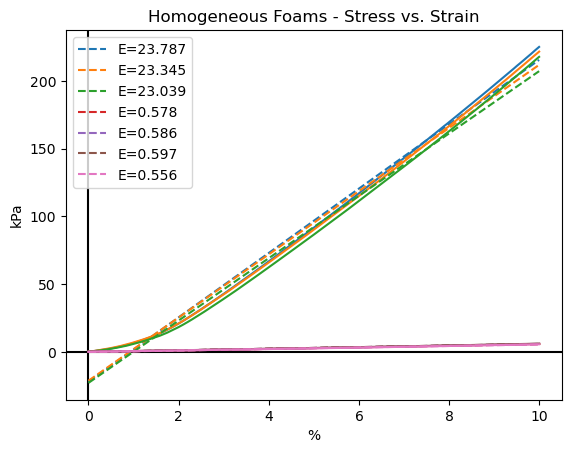

In [3]:
# Load Data
dir = './homogeneous_foam_test_data'
dfs, metadata = load_samples(dir)

# Plotting
fig, ax = plt.subplots()
ax.axvline(color='k')
ax.axhline(color='k')
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'

xlim = (0, 0.1)

for i, df in enumerate(dfs):
    mask = (df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])
    ax.plot(df[x_col][mask], df[y1_col][mask])
    ax.plot(df[x_col][mask], df[y2_col][mask],
            linestyle='dashed',
            color=ax.lines[-1].get_color(),
            label=f"E={metadata[i]['slope']:.3f}")

ax.legend()
ax.set(title='Homogeneous Foams - Stress vs. Strain',
       #   xlabel='Strain (%)',
       #   ylabel='Stress (kPa)'
       )

E_hi = np.mean([m['slope'] for m in metadata if m['slope'] > 1.])
E_lo = np.mean([m['slope'] for m in metadata if m['slope'] < 1.])
mod_ratio = E_hi / E_lo
print(f"High-Low Density Modulus Ratio: {mod_ratio:.3f}")

# Foam Metamaterials

clean_241217_metamaterial_foams_1_1
clean_241217_metamaterial_foams_2_1
clean_241217_metamaterial_foams_3_1


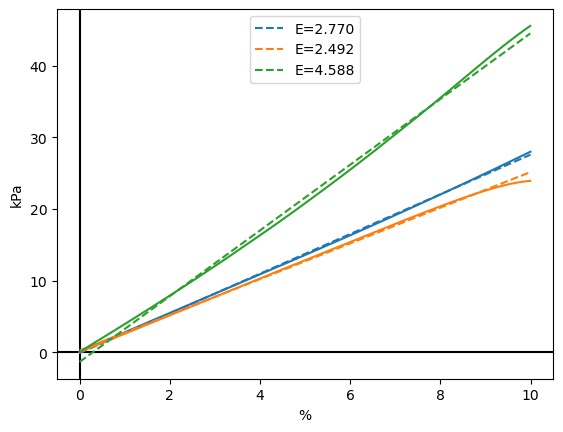

In [ ]:
dir = './241217_metamaterial_foam_test_data'
dfs, metadata = load_samples(dir)
# Test 1 is HSA 529
# Test 2 is BULK-2 539
# Test 3 is BULK-1 510

# Plotting
fig, ax = plt.subplots()
ax.axvline(color='k')
ax.axhline(color='k')
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'

xlim = (0, 0.1)

for i, df in enumerate(dfs):
    mask = (df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])
    ax.plot(df[x_col][mask], df[y1_col][mask])
    ax.plot(df[x_col][mask], df[y2_col][mask],
            linestyle='dashed',
            color=ax.lines[-1].get_color(),
            label=f"E={metadata[i]['slope']:.3f}")
    print(metadata[i]['filename'])

ax.legend()

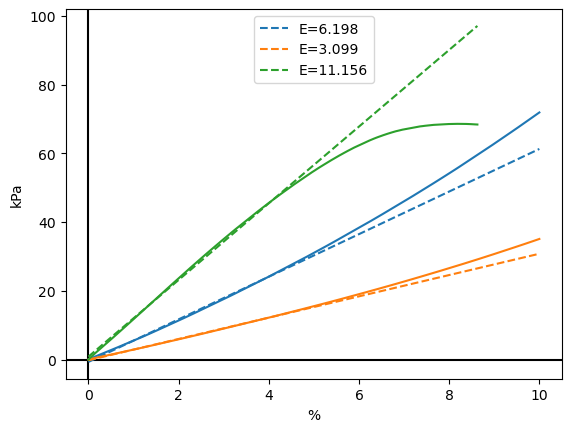

In [20]:
dir = './250106_metamaterial_foam_test_data'
dfs, metadata = load_samples(dir, fit_strain_limits=(0, .05))
# Test 1 was the alternative auxetic
# Test 2 was the VERT compliant dir
# Test 3 was the VERT rigid dir

# Plotting
fig, ax = plt.subplots()
ax.axvline(color='k')
ax.axhline(color='k')
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'

xlim = (0, 0.1)

for i, df in enumerate(dfs):
    mask = (df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])
    ax.plot(df[x_col][mask], df[y1_col][mask])
    ax.plot(df[x_col][mask], df[y2_col][mask],
            linestyle='dashed',
            color=ax.lines[-1].get_color(),
            label=f"E={metadata[i]['slope']:.3f}")


ax.legend()